In [ ]:
import numpy as np
from matplotlib import  pyplot as plt
from tqdm import tqdm
import pickle
import os
from random import shuffle
from IPython.display import clear_output


In [ ]:
np.random.seed(42)

##Загрузка и предобработка данных

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2022-06-13 13:01:40--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  34.0MB/s    in 7.4s    

2022-06-13 13:01:48 (21.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
!tar xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
!ls -lah cifar-10-batches-py  

total 178M
drwxr-xr-x 2 2156 1103 4.0K Jun  4  2009 .
drwxr-xr-x 1 root root 4.0K Jun 13 13:01 ..
-rw-r--r-- 1 2156 1103  158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103   88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 test_batch


In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
d = unpickle('cifar-10-batches-py/data_batch_1')

In [ ]:
d.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

У нас 5 файлов на трейн и один на тест, в каждом по 10000 картинок

In [ ]:
print(d[b'data'].shape)
d[b'data'].shape[0] == len(d[b'labels'])

(10000, 3072)


True

In [ ]:
def collect_data(dirname, key):
    train_images = []
    train_labels = []
    if key == 'train':
        prep_files = [f'data_batch_{i}' for i in range(1,6)]
    elif key == 'test':
        prep_files = ['test_batch']
    else:
        raise KeyError('Unexpected key, input train or test')
    files = map(lambda name: os.path.join(dirname, name), prep_files)
    for file in files:
        dicti = unpickle(file)
        #train_images = np.append(train_images, dicti[b'data'])
        #train_labels = np.append(train_labels, dicti[b'labels'])
        train_images.extend(dicti[b'data'])
        train_labels.extend(dicti[b'labels'])

    return np.array(train_images).astype("float"), np.array(train_labels)

dirname = 'cifar-10-batches-py/'
train_images0, train_labels0 = collect_data(dirname, 'train')
test_images, test_labels = collect_data(dirname, 'test')

In [ ]:
print(train_images0.shape)
print(len(train_images0), len(train_labels0))
len(test_images), len(test_labels)

(50000, 3072)
50000 50000


(10000, 10000)

In [ ]:
#prep_train_labels0 = np.zeros((len(train_labels0), 10))
prep_train_labels0 = np.ones((len(train_labels0), 10)) * (-1.)
for i in range(len(train_labels0)):
    prep_train_labels0[i, train_labels0[i]] = 1.
train_labels0 = prep_train_labels0#.copy()

In [ ]:
prep_test_labels = np.ones((len(test_labels), 10)) * (-1.)
#prep_test_labels = np.zeros((len(test_labels), 10))
for i in range(len(test_labels)):
    prep_test_labels[i, test_labels[i]] = 1.
test_labels = prep_test_labels

In [ ]:
train_images0 /= 255
test_images /= 255

In [ ]:
k = int(len(train_labels0) * 0.9)
val_images = train_images0[k:].copy()
val_labels = train_labels0[k:].copy()
train_images = train_images0[:k].copy()
train_labels = train_labels0[:k].copy()

len(val_images), len(val_labels)

(5000, 5000)

In [ ]:
class DataLoader:
    def __init__(self, images, labels, batch_size):
        self.images = images 
        self.labels = labels 
        self.batch_size = batch_size
        self.max_ind = len(labels) // batch_size 
        if self.max_ind != len(labels) / batch_size:
            self.max_ind += 1
        self.ind = 0
    def __len__(self):
        return self.max_ind
    
    def __call__(self):
        batch_image = self.images[self.ind * self.batch_size:\
                                  min((self.ind + 1) * self.batch_size, len(self.labels))]
        batch_label = self.labels[self.ind * self.batch_size:\
                                  min((self.ind + 1) * self.batch_size, len(self.labels))]
        self.ind += 1
        if self.ind == self.max_ind:
            self.ind = 0
        return batch_image, batch_label

def test():
  batch_loader = DataLoader(train_images, train_labels, 32)
  x,y = batch_loader()
  print(x.shape, y.shape, len(batch_loader))

test()

(32, 3072) (32, 10) 1407


##Построение модели

In [ ]:
class Linear:
    def __init__(self, in_size, out_size, weights, bias):
        self.in_size = in_size
        self.out_size = out_size
        self.weights = weights
        self.bias = bias
    
    def forward(self, x):
        return x @ self.weights + self.bias

    def backward(self, x):
        grad_w = x.T
        grad_b = np.ones(x.shape[0])
        grad_x = self.weights.T
        return grad_w, grad_b, grad_x

In [ ]:
def limit_exp(arr):
    res = arr.copy()
    # res[res > 10] = np.exp(10)
    # res[res < -10] = np.exp(-10)
    # res[(res < 10) & (res > -10)] = np.exp(res[(res < 10) & (res > -10)])
    res = np.exp(np.clip(res, -20, 20))
    return res

In [ ]:
class sigmoid:
    def forward(self, x):
        return 1 / (1  + limit_exp(-x))
    def backward(self, x):
        return  limit_exp(x) / ((1 + limit_exp(-x)) ** 2)

class tanh:
    def forward(self, x):
        return (limit_exp(x) - limit_exp(-x)) / (limit_exp(x) + limit_exp(-x))
    def backward(self, x):
        return 4. / ((limit_exp(x) + limit_exp(-x)) ** 2)

class ReLu:
    def forward(self, x):
        return np.maximum(x, np.zeros(x.shape))
    def backward(self, x):
        return (x > np.zeros(x.shape)).astype(float)

In [ ]:
# class sigmoid:
#     def forward(self, x):
#         return np.clip(1 / (1  + np.exp(-x)), 1e-6, 1e+6)
#     def backward(self, x):
#         return  np.clip(np.exp(x) / ((1 + np.exp(-x)) ** 2), 1e-6, 1e+6)
# class tanh:
#     def forward(self, x):
#         return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
#     def backward(self, x):
#         return 4. / ((np.exp(x) + np.exp(-x)) ** 2)

# class ReLu:
#     def forward(self, x):
#         return np.maximum(x, np.zeros(x.shape))
#     def backward(self, x):
#         return (x > np.zeros(x.shape)).astype(float)

In [ ]:
# class softmax:
#     def forward(self, x):
#         res = np.zeros(x.shape)
#         #temp_x = x.copy()
#         # x[x < -1e+2] = -1e+2
#         # x[x > 1e+2] = 1e+2
#         # temp_x[temp_x < -1e+2] = -1e+2
#         # temp_x[temp_x > 1e+2] = 1e+2
#         for i in range((len(res))):
#             #temp = np.exp(temp_x[i] - np.max(temp_x[i]) )
#             #temp = np.exp(x[i] - np.max(x[i]) )
#             temp = np.exp(np.clip(x[i], 1e-2, 1e+2))
#             res[i] = temp / np.sum(temp)
#         #res[res < 0.01] = 0.01
#         #res[res > 0.9] = 0.9
#             #res[i] = np.exp(x[i]) / np.sum(np.exp(x[i]))
#         return res
#     # e_x = np.exp(x - np.max(x, axis=1).reshape(-1,1))
#     # softmax =  e_x / e_x.sum(axis=1).reshape(-1,1)
#     # return softmax
#         #return np.exp(x) / np.sum(np.exp(x), axis=1)
        
#     def backward(self, x):
#         k = len(x)
#         #temp = np.exp(x) 
#         #temp_x = x.copy()
#         # x[x < -1e+2] = -1e+2
#         # x[x > 1e+2] = 1e+2 
#         # temp_x[temp_x < -1e+2] = -1e+2
#         # temp_x[temp_x > 1e+2] = 1e+2
#         #s = np.exp(temp_x - np.max(temp_x) ) / np.sum(np.exp(temp_x - np.max(temp_x)) )
#         s = np.exp(np.clip(x, 1e-1, 1e+1)) / np.sum(np.exp(np.clip(x, 1e-1, 1e+1)))
#         #s = np.exp(x - np.max(x) ) / np.sum(np.exp(x - np.max(x)) )
#         #s[s < 0.01] = 0.01
#         #s[s > 0.9] = 0.9
#         #s[s < 0.01] = 0.01

#         #s = np.exp(x) / np.sum(np.exp(x))
#         res = np.zeros((k,k))
#         for i in range(k):
#             res[i] = s[i] * s       
#             res[i, i] = s[i] * (1 - s[i])    
#         return res

In [ ]:
class Hingeloss:
    def __call__(self, y_pred, y_true):
        self.size = y_true.shape
        self.true_labels = np.argmax(y_true, axis=1)
        neg = np.max((1. - y_true) * y_pred, axis=1)
        self.max_ind = np.argmax((1. - y_true) * y_pred, axis=1)
        pos = np.sum(y_true * y_pred, axis=1)
        itog = neg - pos + 1.
        self.check = np.array(list(map(lambda x: x > 0, itog)))
        #loss = np.max(np.vstack((itog, np.zeros(len(y_pred)))), axis=0)
        loss = np.mean(np.max(np.vstack((itog, np.zeros(len(y_pred)))), axis=0))
        return loss

    def backward(self):
        dy_pred = np.zeros(self.size)
        for i in range(len(dy_pred)):
            if  not self.check[i]:
                 continue
            dy_pred[i, self.max_ind[i]] += 1.
            dy_pred[i, self.true_labels[i]] -= 1.
        return dy_pred

In [ ]:
class Hingeloss2:
    def __call__(self, y_pred, y_true):
        self.size = y_true.shape
        self.true_labels = np.argmax(y_true, axis=1)
        res = np.zeros(self.size[0])
        self.grad = np.zeros(self.size)

        for i in range(self.size[0]):
            for j in range(self.size[1]):
                if j != self.true_labels[i]:
                    if 1 + y_pred[i, j] - y_pred[i, self.true_labels[i]] > 0:
                        res[i] += 1 + y_pred[i, j] - y_pred[i, self.true_labels[i]]
                        self.grad[i, j] += 1
                        self.grad[i, self.true_labels[i]] -= 1
        loss = np.mean(res)
        return loss

    def backward(self):
        return self.grad

In [ ]:
# class CrossEnthropy:
#     def __call__(self, y_pred, y_true):
#         self.size = y_true.shape
#         self.true_labels = np.argmax(y_true, axis=1)
#         # neg = np.max((1 - y_true) * y_pred, axis=1)
#         # self.max_ind = np.argmax((1 - y_true) * y_pred, axis=1)
#         # pos = np.sum(y_true * y_pred, axis=1)
#         # itog = neg - pos + 1
#         # self.check = np.array(list(map(lambda x: x > 0, itog)))
#         # loss = np.mean(np.max(np.vstack((neg - pos + 1, np.zeros(len(y_pred)))), axis=0))
#         #y_pred[y_pred < 0.01] = 0.01
#         self.gr = -y_true / y_pred  #(y_pred + 1e-6)
#         loss = np.mean(-np.sum(np.log(y_pred) * y_true, axis=1))
#         return loss

#     def backward(self):
#         #dy_pred = np.zeros(self.size)
#         #for i in range(len(dy_pred)):
#             #if  not self.check[i]:
#                 #continue
#             #dy_pred[i, self.max_ind[i]] += 1
#             #dy_pred[i, self.true_labels[i]] -= 1
#         res = self.gr
#         return res

In [ ]:
class Fully_NN:
    def __init__(self, all_sizes, lr, loss_func, act_func=ReLu()):
        np.random.seed(42)
        self.prep_x = np.array([])
        self.lr = lr
        self.loss_func = loss_func
        self.act_func = act_func
        self.all_layers = np.zeros(len(all_sizes) - 1, dtype=object) 
       
        self.act_mem = np.zeros(len(self.all_layers) - 1, dtype=object)
        self.matr_mem = np.zeros(len(self.all_layers) - 1, dtype=object)
        for i in range(len(all_sizes) - 1):
            self.all_layers[i] = Linear(
            all_sizes[i], all_sizes[i + 1], 
            np.random.randn(all_sizes[i], all_sizes[i+1]) * np.sqrt(2. / all_sizes[i]),
            np.zeros(all_sizes[i + 1])
            )
           
    def forward(self, x):
        self.init_x = x
        for i in range(len(self.all_layers) - 1):
            self.matr_mem[i] = self.all_layers[i].forward(x)
            self.act_mem[i] = self.act_func.forward(self.matr_mem[i])
            x = self.act_mem[i]
       
        res = self.all_layers[-1].forward(x)
        return res

    def calc_loss(self, y_pred, y):
        res = self.loss_func(y_pred, y)
        return res 
    
    def backward(self): #, x):
        dy_pred = self.loss_func.backward()
        n_samples = dy_pred.shape[0]
        
        #soft_gr = np.zeros(n_samples, dtype = object)
        #for i in range(n_samples):
            #soft_gr[i] = softmax().backward(self.prep_x[i])
           
        #gr_before_soft = sigmoid().backward(self.prep_x)

        #gr_before_soft = np.zeros(dy_pred.shape)
        #gr_before_soft = np.zeros(n_samples, dtype = object)
        #for i in range(n_samples):
            #gr_before_soft[i] = dy_pred[i] @ soft_gr[i].T
       
        if len(self.all_layers) == 1:
            gr1_w, gr1_b, gr1_x = self.all_layers[-1].backward(self.init_x)
        else:
            gr1_w, gr1_b, gr1_x = self.all_layers[-1].backward(self.act_mem[-1])
      
        self.all_layers[-1].weights -= self.lr * gr1_w @ dy_pred / n_samples
        self.all_layers[-1].bias -= self.lr * gr1_b @ dy_pred / n_samples
        temp_x = dy_pred @ gr1_x

        for i in range(len(self.all_layers) - 2, -1, -1):
            temp_x *= self.act_func.backward(self.matr_mem[i])
            
            if i == 0:
                gr_w, gr_b, gr_x = self.all_layers[i].backward(self.init_x)

            else:
                gr_w, gr_b, gr_x = self.all_layers[i].backward(self.act_mem[i - 1])
          
            self.all_layers[i].weights -= self.lr * gr_w @ temp_x / n_samples
            self.all_layers[i].bias -= self.lr * gr_b @ temp_x / n_samples
            temp_x = temp_x @ gr_x


### Проверка градиентов

Выполним сначала проверку градиентов как численную, так и с точки зрения масштаба

In [ ]:
def grad_check(x, y, eps=1e-6):
    neural_net = Fully_NN(
                      all_sizes=[x.shape[1],  10, y.shape[1]], 
                      lr=1e-4,
                      loss_func = Hingeloss2(),
                      act_func=ReLu())
    num_grad = []
    backprop_grad = []
    prev_weights = []
    new_weights = []
    for layer in neural_net.all_layers:
        for i in range(layer.weights.shape[0]):
            for j in range(layer.weights.shape[1]):
                layer.weights[i, j] += eps
                y_plus = neural_net.forward(x)
                J_plus = neural_net.calc_loss(y_plus, y)

                layer.weights[i, j] -= 2 * eps
                y_minus = neural_net.forward(x)
                J_minus = neural_net.calc_loss(y_minus, y)
                
                layer.weights[i, j] += eps
                num_grad.append((J_plus - J_minus) / (2 * eps))
                prev_weights.append(layer.weights[i, j])    

        for i in range(layer.bias.shape[0]):
            layer.bias[i] += eps
            y_plus = neural_net.forward(x)
            J_plus = neural_net.calc_loss(y_plus, y)

            layer.bias[i] -= 2 * eps
            y_minus = neural_net.forward(x)
            J_minus = neural_net.calc_loss(y_minus, y)
            
            layer.bias[i] += eps
            num_grad.append((J_plus - J_minus) / (2 * eps))
            prev_weights.append(layer.bias[i])

    y_pred = neural_net.forward(x)
    neural_net.calc_loss(y_pred, y)
    neural_net.backward()
    for layer in neural_net.all_layers:
        for i in range(layer.weights.shape[0]):
            for j in range(layer.weights.shape[1]):
                new_weights.append(layer.weights[i, j])

        for i in range(layer.bias.shape[0]):
            new_weights.append(layer.bias[i])

    backprop_grad = (np.array(prev_weights) - np.array(new_weights)) / neural_net.lr

    num_grad = np.array(num_grad)
    print(np.linalg.norm(num_grad), np.linalg.norm(backprop_grad))

    numerator = np.linalg.norm(num_grad - backprop_grad)
    denominator = np.linalg.norm(num_grad) + np.linalg.norm(backprop_grad)
    diff = numerator / denominator

    if diff > eps:
        print('Backprop calculation is not ok!')
    else:
        print('Backprop calculation is ok!')

    scale_check = (np.linalg.norm(backprop_grad * (-neural_net.lr)) / np.linalg.norm(prev_weights))
    if scale_check <= 1e-2 and scale_check >= 1e-4:
        print('Backprop scale is ok!')
    else:
        print('Backprop scale is not ok!')
    return diff, scale_check

In [ ]:
check_loader = DataLoader(train_images, train_labels, 8)
x_batch, y_batch = check_loader()
grad_check(x_batch, y_batch)

86.91170942896166 86.89950961486838
Backprop calculation is not ok!
Backprop scale is ok!


(0.0001385792766683512, 0.0014188752583428148)

Видим, что по масштабу проверка проходит, а по точности немного не хватает

### Обучение моделей и эксперименты

Попробуем теперь обучить нашу модель

In [ ]:
def eval_acc(y_pred, y_true):
    pred_label = np.argmax(y_pred, axis=1)
    true_label = np.argmax(y_true, axis=1)
    accuracy = (pred_label == true_label).mean()
    return accuracy

In [ ]:
def train_model(model, num_epochs, train_set, val_set):
    train_epoch_loss_array, train_epoch_acc_array = [], []
    val_epoch_loss_array, val_epoch_acc_array = [], []
    #check = []
    for epoch in tqdm(range(num_epochs)):
        train_epoch_loss, train_epoch_acc = 0, 0
        for _ in range(len(train_set)):
            x_batch, y_batch = train_set()

            y_batch_pred = model.forward(x_batch)
            train_batch_loss = model.calc_loss(y_batch_pred, y_batch)
            model.backward()
            #check.append(train_batch_loss)

            train_epoch_loss += train_batch_loss
            train_epoch_acc += eval_acc(y_batch_pred, y_batch)    

        train_epoch_loss_array.append(train_epoch_loss / len(train_set))
        train_epoch_acc_array.append(train_epoch_acc / len(train_set))

        val_epoch_loss, val_epoch_acc = 0, 0
        for _ in range(len(val_set)):
            x_batch, y_batch = val_set()
            y_batch_pred = model.forward(x_batch)
            val_batch_loss = model.calc_loss(y_batch_pred, y_batch)

            val_epoch_loss += val_batch_loss
            val_epoch_acc += eval_acc(y_batch_pred, y_batch)
        val_epoch_loss_array.append(val_epoch_loss / len(val_set))
        val_epoch_acc_array.append(val_epoch_acc / len(val_set))
    return train_epoch_loss_array, val_epoch_loss_array, train_epoch_acc_array, val_epoch_acc_array

In [ ]:
def draw_plots(arrs):
    fig = plt.figure(figsize=[20, 10])
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(arrs[0], label='train')
    ax1.plot(arrs[1], label='val')
    plt.title('Train Loss')
    ax1.grid()
    ax1.legend()
    ax2 = fig.add_subplot(1, 2, 2)
    plt.title('Train Acc')
    ax2.grid()
    ax2.plot(arrs[2], label='train')
    ax2.plot(arrs[3], label='val')
    ax2.legend()
    plt.show()

In [ ]:
def eval_test(model, test_set):
    test_acc = 0
    for _ in range(len(test_set)):
        x_batch, y_batch = test_set()
        y_batch_pred = model.forward(x_batch)
        test_acc += eval_acc(y_batch_pred, y_batch)
    return test_acc / len(test_set)

100%|██████████| 10/10 [01:19<00:00,  8.00s/it]


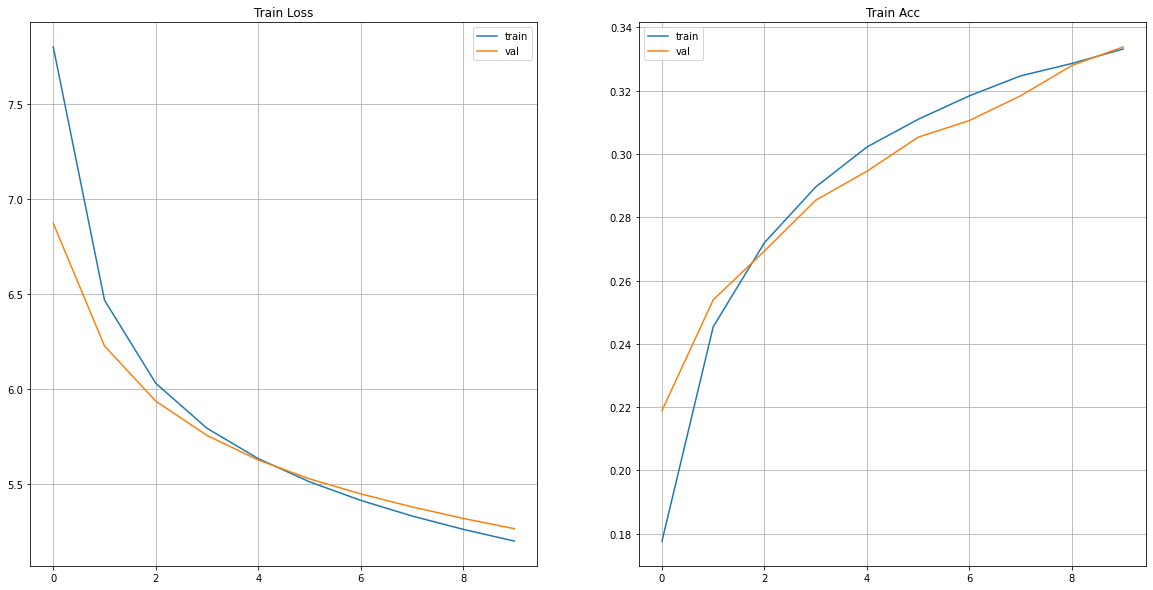

0.32832278481012656

In [ ]:
np.seterr(all='raise')
EPOCH_NUMBER = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.0001

train_dataloader = DataLoader(train_images, train_labels, BATCH_SIZE)
val_dataloader = DataLoader(val_images, val_labels, BATCH_SIZE)
test_dataloader = DataLoader(test_images, test_labels, BATCH_SIZE)

neural_net = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=LEARNING_RATE,
                      #loss_func = CrossEnthropy(),
                      loss_func = Hingeloss2(),
                      act_func=ReLu())
                      #act_func=sigmoid())

arrs = train_model(neural_net, EPOCH_NUMBER, train_dataloader, val_dataloader)
draw_plots(arrs)

eval_test(neural_net, test_dataloader)


Видим, что модель обучается, т.е. лосс падает, а метрика растет. Это была ReLu. Теперь посмотрим, как влияют на обучение другие функции активации

100%|██████████| 10/10 [01:23<00:00,  8.38s/it]


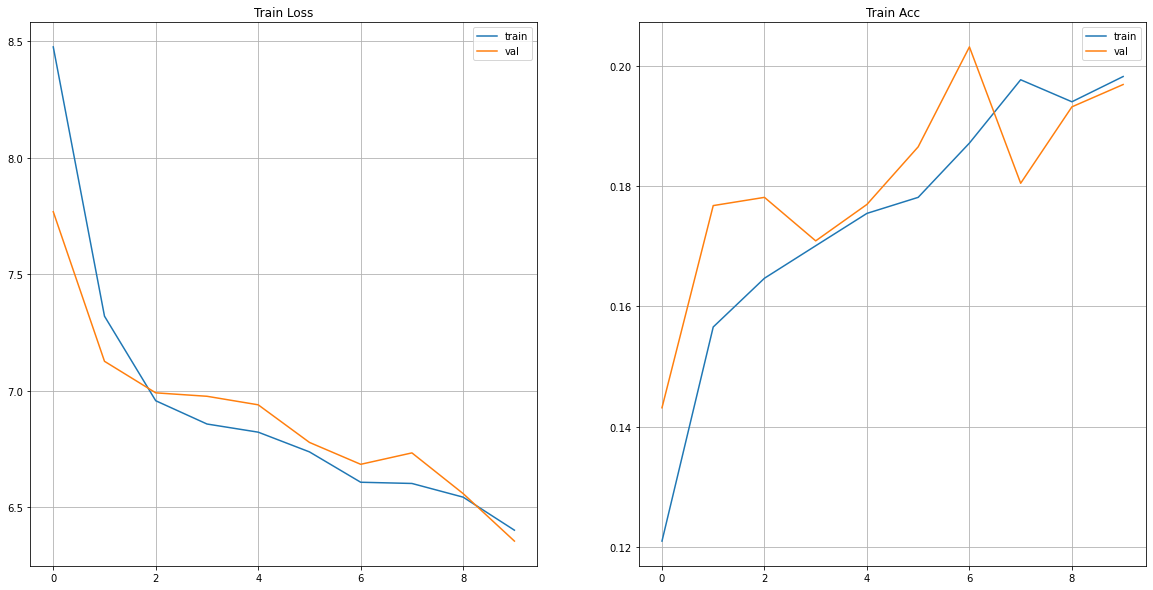

0.19165348101265822

In [ ]:
#sigmoid
neural_net_sigm = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=1e-2,
                      #loss_func = CrossEnthropy(),
                      loss_func = Hingeloss2(),
                      #act_func=ReLu())
                      act_func=sigmoid())

arrs_sigm = train_model(neural_net_sigm, EPOCH_NUMBER, train_dataloader, val_dataloader)
draw_plots(arrs_sigm)
eval_test(neural_net_sigm, test_dataloader)

100%|██████████| 10/10 [01:21<00:00,  8.20s/it]


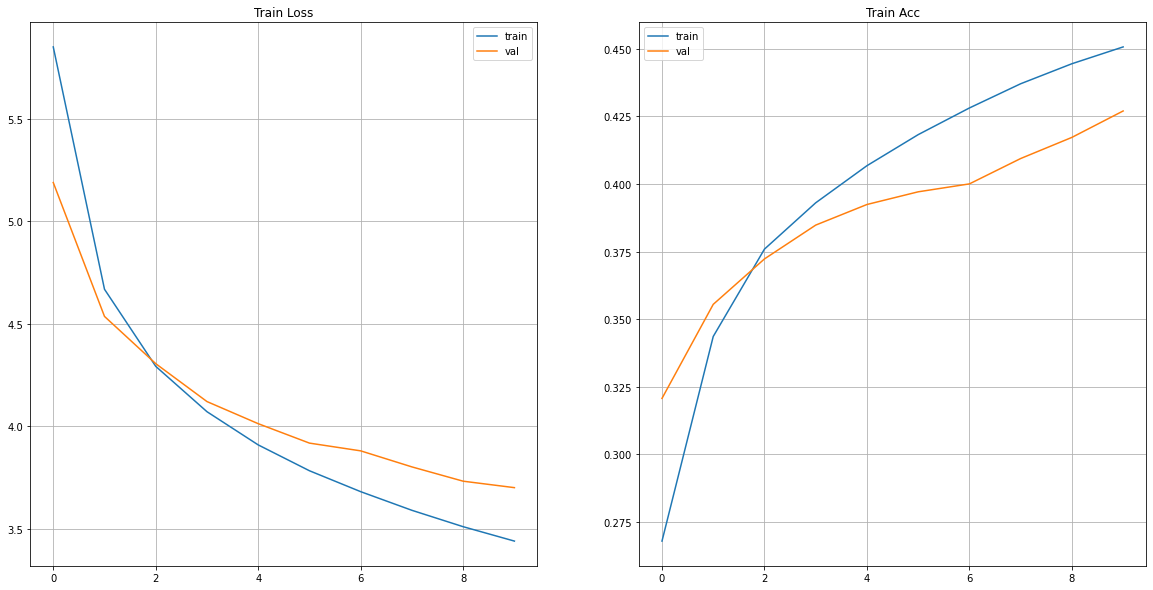

0.4307753164556962

In [ ]:
#tanh
neural_net_tanh = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=1e-2,
                      #loss_func = CrossEnthropy(),
                      loss_func = Hingeloss2(),
                      #act_func=ReLu())
                      act_func=tanh())

arrs_tanh = train_model(neural_net_tanh, EPOCH_NUMBER, train_dataloader, val_dataloader)
draw_plots(arrs_tanh)
eval_test(neural_net_tanh, test_dataloader)

Для сигмоиды и tanh взял урезанные значения экспоненты, т.к. там легко вылезти за границы(слишком большое или слишком маленькое число), и поэтому для них взял lr побольше. Как и ожидалось, при tanh модель обучается лучше, причем она обучилась даже лучше, чем при использовании ReLU(и по метрике, и по лоссу). Но корректнее сравнивать обучение моделей при одном значении lr

100%|██████████| 10/10 [01:27<00:00,  8.72s/it]


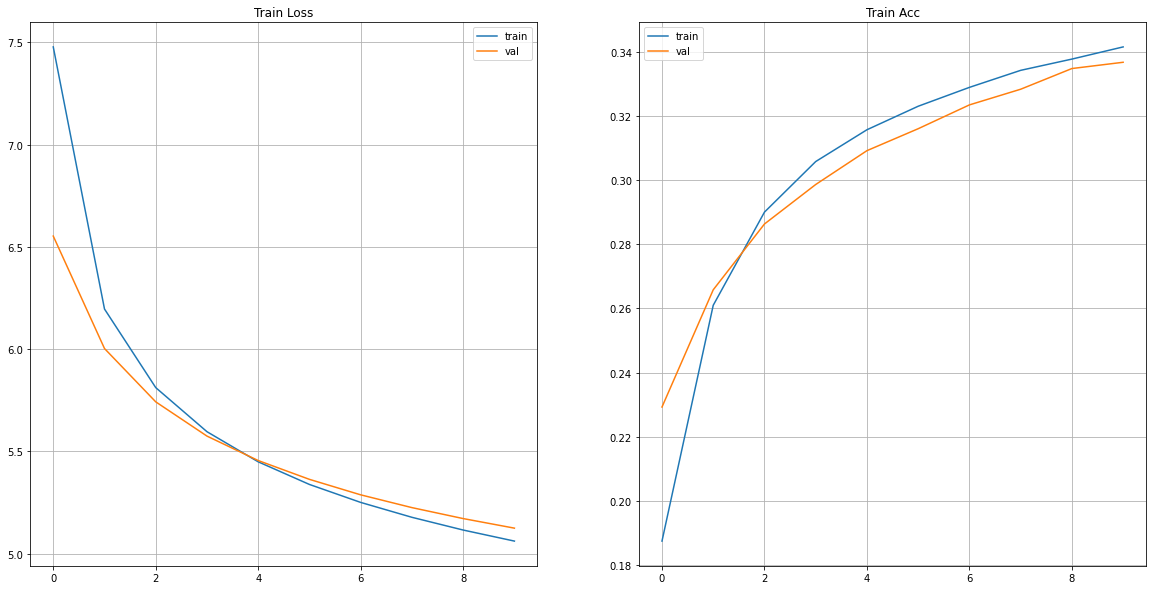

0.33188291139240506

In [118]:
#tanh
neural_net_tanh = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=LEARNING_RATE,
                      #loss_func = CrossEnthropy(),
                      loss_func = Hingeloss2(),
                      #act_func=ReLu())
                      act_func=tanh())

arrs_tanh = train_model(neural_net_tanh, EPOCH_NUMBER, train_dataloader, val_dataloader)
draw_plots(arrs_tanh)
eval_test(neural_net_tanh, test_dataloader)

В итоге при одинаковом lr модели обучаются схожим образом, но, можно заметить, что с самого начала с функцией активации tanh модель обучается лучше(ведь возле 0 градиенты будут больше)

Далее возьмем два метода обучения, а именно классический GD и SGD, и посмотрим, с каким модель будет обучаться лучше

In [133]:
train_images.shape

(45000, 3072)

100%|██████████| 300/300 [31:07<00:00,  6.22s/it]


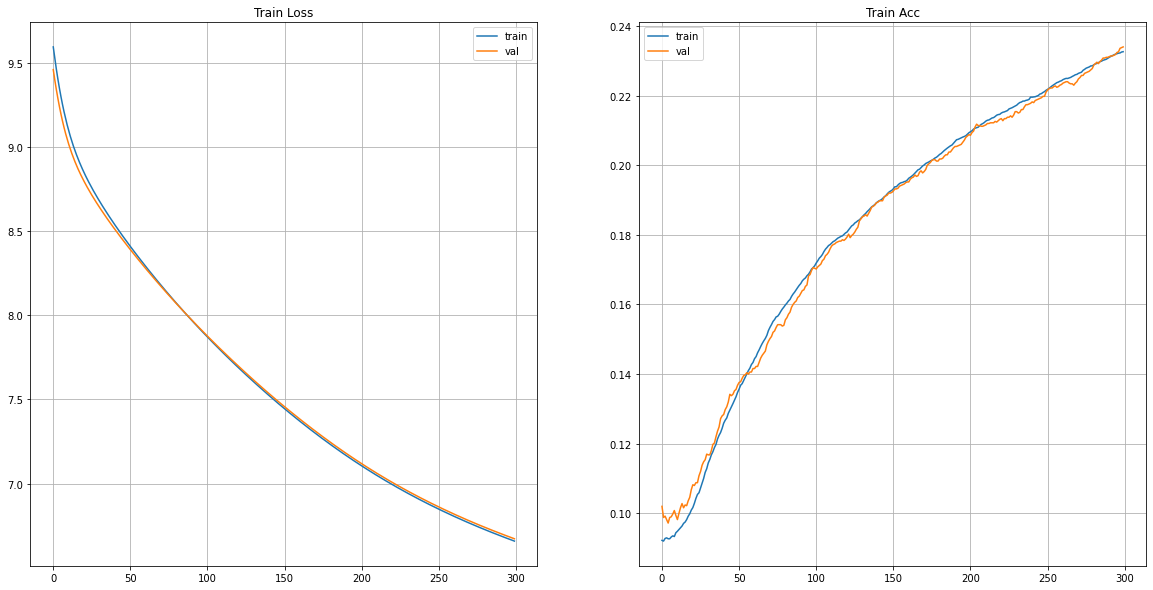

0.2325

In [136]:
BATCH_SIZE_GD = train_labels.shape[0]

train_dataloader_gd = DataLoader(train_images, train_labels, BATCH_SIZE_GD)
val_dataloader_gd = DataLoader(val_images, val_labels, BATCH_SIZE_GD)
test_dataloader_gd = DataLoader(test_images, test_labels, BATCH_SIZE_GD)

neural_net_gd = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=LEARNING_RATE,
                      loss_func = Hingeloss2(),
                      act_func=tanh())

arrs_gd = train_model(neural_net_gd, 300, train_dataloader_gd, val_dataloader_gd)
draw_plots(arrs_gd)

eval_test(neural_net_gd, test_dataloader_gd)


100%|██████████| 10/10 [24:15<00:00, 145.57s/it]


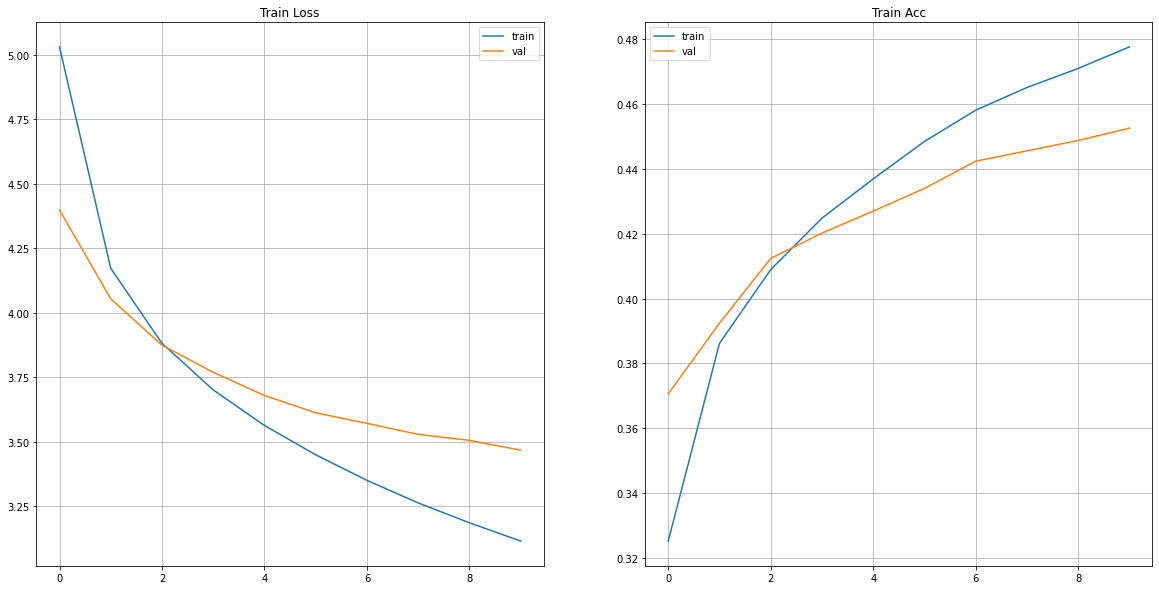

0.4545

In [131]:
BATCH_SIZE_SGD = 1

train_dataloader_sgd = DataLoader(train_images, train_labels, BATCH_SIZE_SGD)
val_dataloader_sgd = DataLoader(val_images, val_labels, BATCH_SIZE_SGD)
test_dataloader_sgd = DataLoader(test_images, test_labels, BATCH_SIZE_SGD)

neural_net_sgd = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=LEARNING_RATE,
                      loss_func = Hingeloss2(),
                      act_func=tanh())

arrs_sgd = train_model(neural_net_sgd, EPOCH_NUMBER, train_dataloader_sgd, val_dataloader_sgd)
draw_plots(arrs_sgd)

eval_test(neural_net_sgd, test_dataloader_sgd)

Сравнивать обучение по эпохам не корректно, т.к. обучение на одной эпохе в данных подходах занимает совершенно разное количество времени, и во время эпохи происходит разное число обновлений весов(45к против 1). Но если сравнивать по времени обучения, мы видим, что при использовании sgd обучение проходит лучше

Теперь будем последовательно менять гиперпараметры модели и смотреть, как будет меняться обучение

Начнем с изменения батча

100%|██████████| 10/10 [01:46<00:00, 10.64s/it]


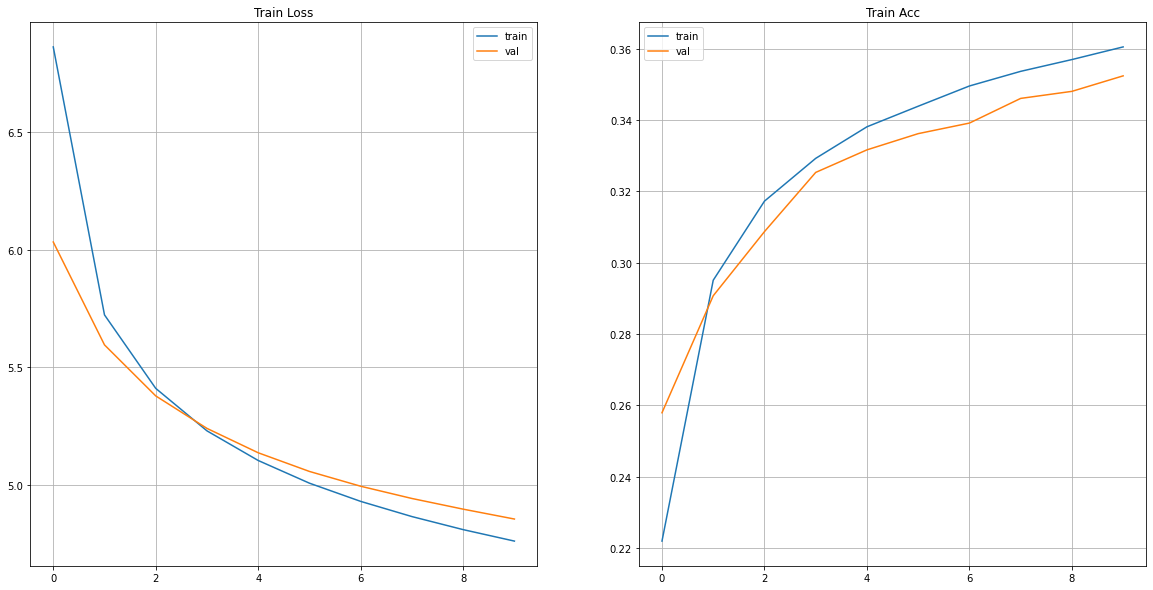

0.34882563694267515

In [140]:
BATCH_SIZE_NEW = 64

train_dataloader_new = DataLoader(train_images, train_labels, BATCH_SIZE_NEW)
val_dataloader_new = DataLoader(val_images, val_labels, BATCH_SIZE_NEW)
test_dataloader_new = DataLoader(test_images, test_labels, BATCH_SIZE_NEW)

neural_net_new = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=LEARNING_RATE,
                      loss_func = Hingeloss2(),
                      act_func=tanh())

arrs_new = train_model(neural_net_new, EPOCH_NUMBER, train_dataloader_new, val_dataloader_new)
draw_plots(arrs_new)

eval_test(neural_net_new, test_dataloader_new)  #0.33188291 batch - 128

100%|██████████| 10/10 [01:24<00:00,  8.48s/it]


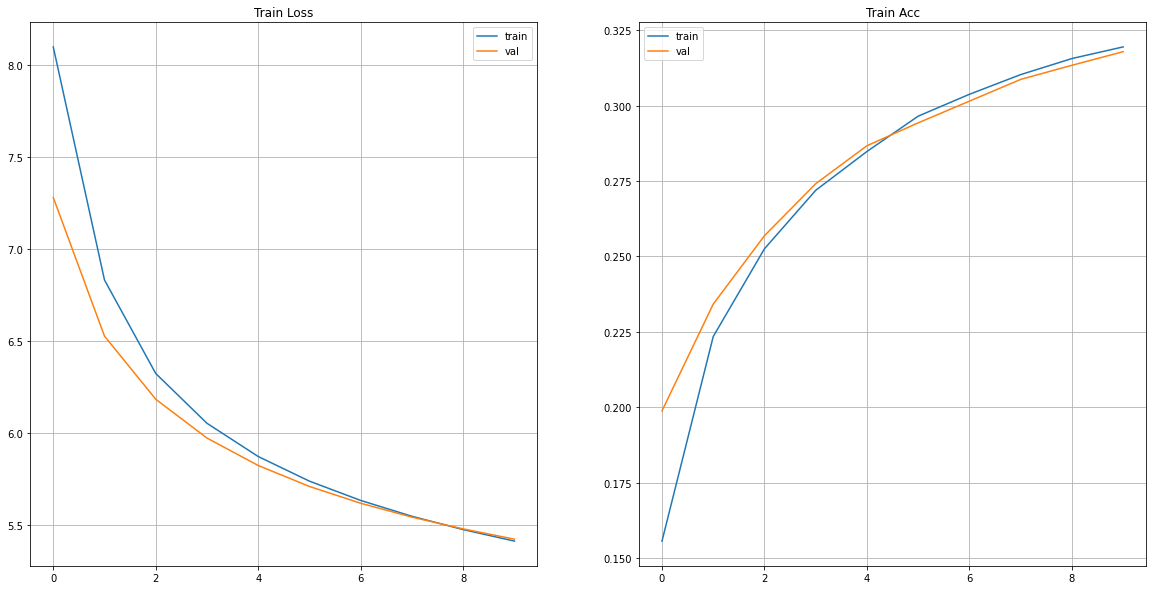

0.30986328125

In [142]:
BATCH_SIZE_NEW2 = 256

train_dataloader_new2 = DataLoader(train_images, train_labels, BATCH_SIZE_NEW2)
val_dataloader_new2 = DataLoader(val_images, val_labels, BATCH_SIZE_NEW2)
test_dataloader_new2 = DataLoader(test_images, test_labels, BATCH_SIZE_NEW2)

neural_net_new2 = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=LEARNING_RATE,
                      loss_func = Hingeloss2(),
                      act_func=tanh())

arrs_new2 = train_model(neural_net_new2, EPOCH_NUMBER, train_dataloader_new2, val_dataloader_new2)
draw_plots(arrs_new2)

eval_test(neural_net_new2, test_dataloader_new2)

100%|██████████| 10/10 [02:03<00:00, 12.30s/it]


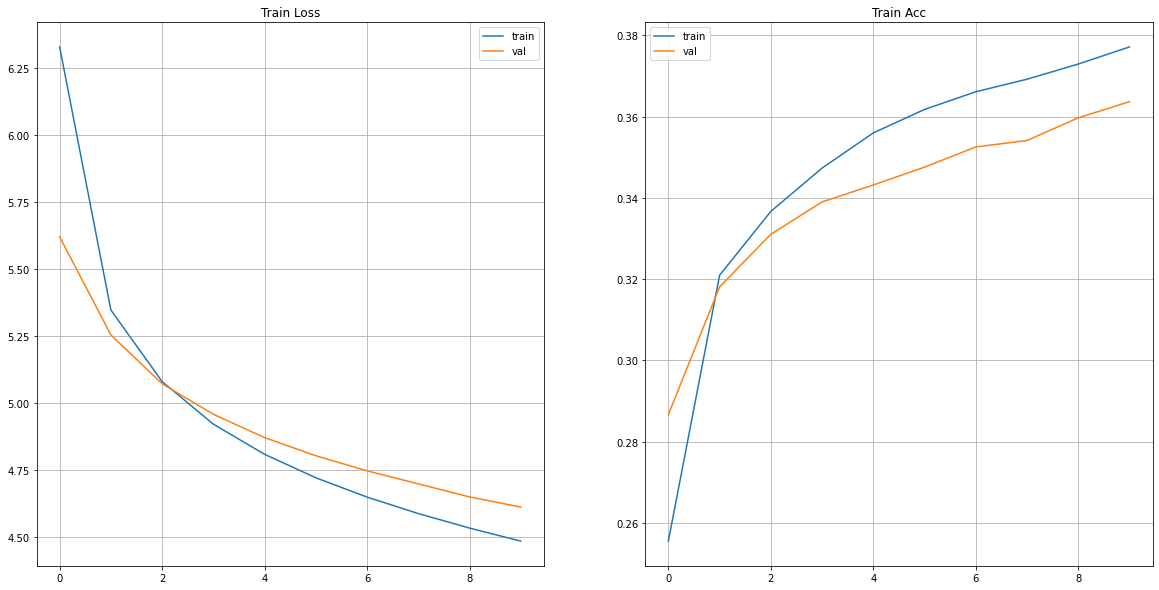

0.3619209265175719

In [145]:
BATCH_SIZE_32 = 32

train_dataloader_32 = DataLoader(train_images, train_labels, BATCH_SIZE_32)
val_dataloader_32 = DataLoader(val_images, val_labels, BATCH_SIZE_32)
test_dataloader_32 = DataLoader(test_images, test_labels, BATCH_SIZE_32)

neural_net_32 = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=LEARNING_RATE,
                      loss_func = Hingeloss2(),
                      act_func=tanh())

arrs_32 = train_model(neural_net_32, EPOCH_NUMBER, train_dataloader_32, val_dataloader_32)
draw_plots(arrs_32)

eval_test(neural_net_32, test_dataloader_32)  #0.33188291

100%|██████████| 10/10 [06:58<00:00, 41.89s/it]


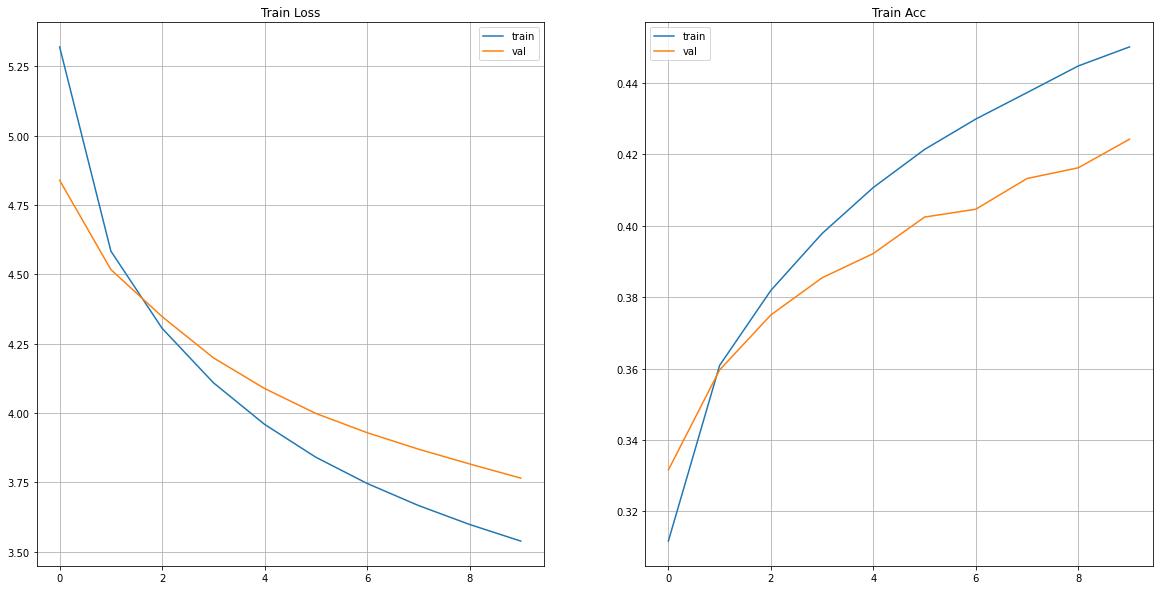

0.4337

In [146]:
BATCH_SIZE_4 = 4

train_dataloader_4 = DataLoader(train_images, train_labels, BATCH_SIZE_4)
val_dataloader_4 = DataLoader(val_images, val_labels, BATCH_SIZE_4)
test_dataloader_4 = DataLoader(test_images, test_labels, BATCH_SIZE_4)

neural_net_4 = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=LEARNING_RATE,
                      loss_func = Hingeloss2(),
                      act_func=tanh())

arrs_4 = train_model(neural_net_4, EPOCH_NUMBER, train_dataloader_4, val_dataloader_4)
draw_plots(arrs_4)

eval_test(neural_net_4, test_dataloader_4)  #0.4545 batch - 1

Видно, что при уменьшении батча модель обучается лучше. Наилучший результат получился с SGD. Но это пока у нас достаточно простая модель и маленький lr

При увеличении lr мы уже видим, что уменьшение батча ухудшило обучение

100%|██████████| 10/10 [01:55<00:00, 11.51s/it]


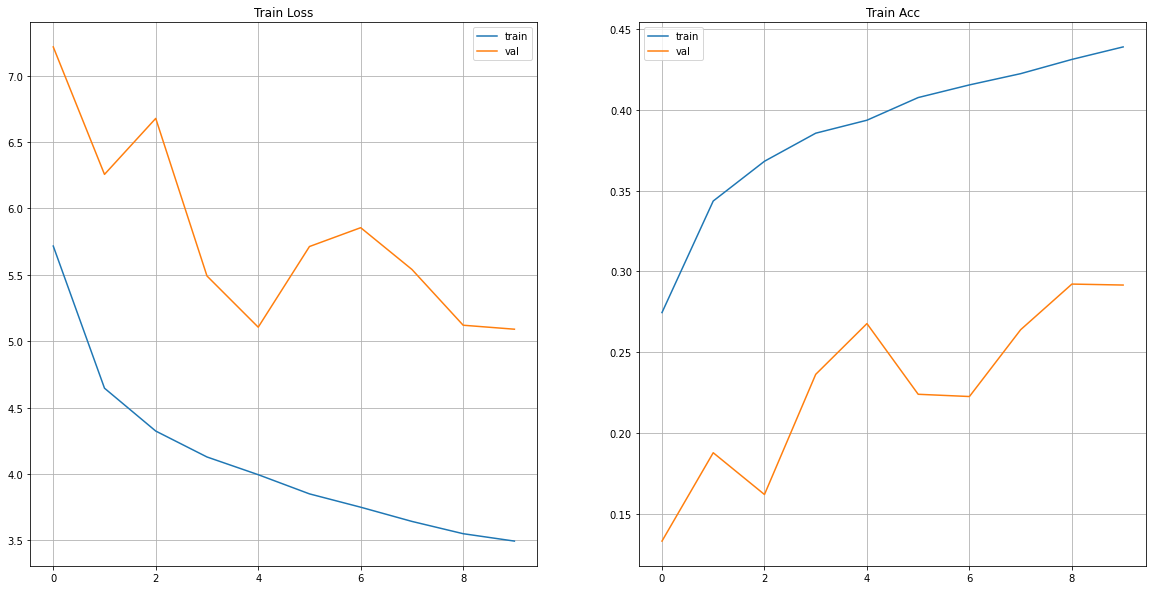

0.28963658146964855

In [150]:
neural_net2_32 = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=1e-2,
                      loss_func = Hingeloss2(),
                      act_func=tanh())

arrs2_32 = train_model(neural_net2_32, EPOCH_NUMBER, train_dataloader_32, val_dataloader_32)
draw_plots(arrs2_32)

eval_test(neural_net2_32, test_dataloader_32)  #0.4307753164556962 batch - 128

Далее, будем увеличивать количество нейронов и добавлять слои в модель

100%|██████████| 10/10 [04:00<00:00, 24.03s/it]


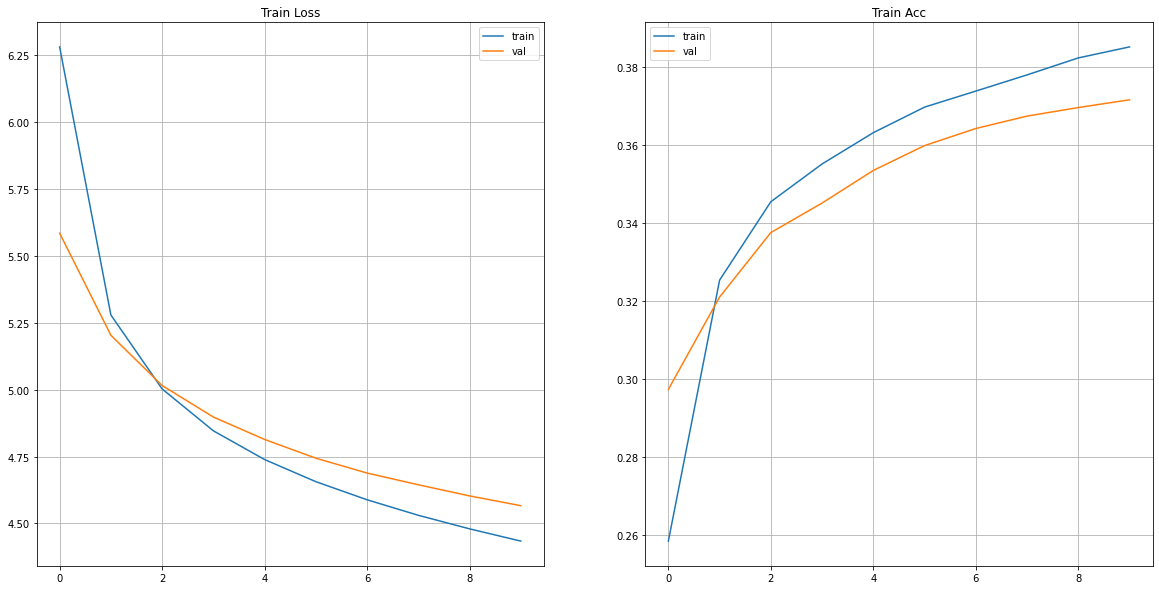

0.3730031948881789

In [153]:
neural_net_tanh_more = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  256, train_dataloader.labels.shape[1]], 
                      lr=LEARNING_RATE,
                      loss_func = Hingeloss2(),
                      act_func=tanh())

arrs_tanh_more = train_model(neural_net_tanh_more, EPOCH_NUMBER, train_dataloader, val_dataloader)
draw_plots(arrs_tanh_more)
eval_test(neural_net_tanh_more, test_dataloader) #0.33188291 with 100 neurons on hidden

100%|██████████| 10/10 [15:38<00:00, 93.84s/it]


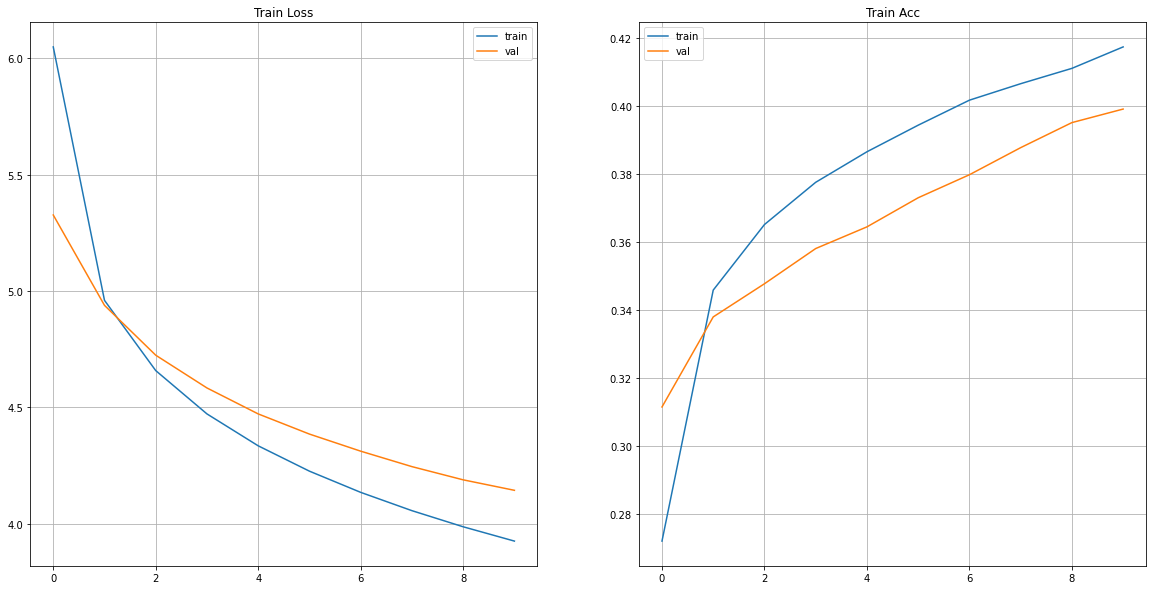

0.39876198083067094

In [154]:
neural_net_tanh_big = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  1024, 256, 64, train_dataloader.labels.shape[1]], 
                      lr=LEARNING_RATE,
                      loss_func = Hingeloss2(),
                      act_func=tanh())

arrs_tanh_big = train_model(neural_net_tanh_big, EPOCH_NUMBER, train_dataloader, val_dataloader)
draw_plots(arrs_tanh_big)
eval_test(neural_net_tanh_big, test_dataloader) #0.33188291

Как при увеличении нейронов, так и при добавлении слоев обучение улучшается, растет обобщающая способность модели

Также посмотрим, как поведет себя модель при большем числе эпох. Тяжелые модели не рассматривал, т.к. обучение было бы слишком долгим

100%|██████████| 30/30 [05:55<00:00, 11.87s/it]


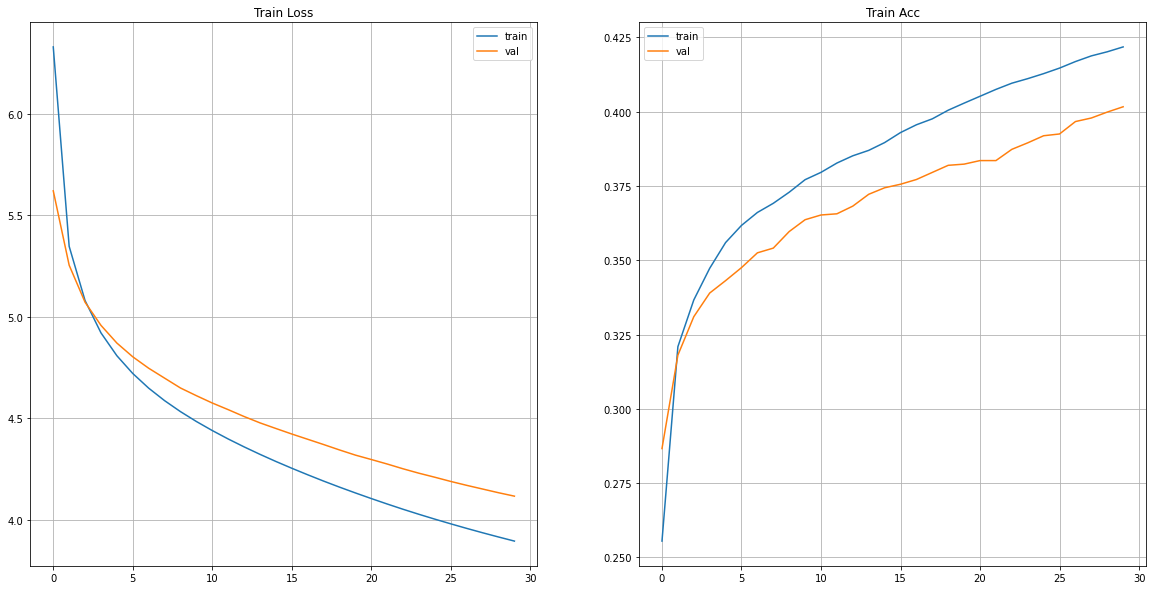

0.40525159744408945

In [157]:
neural_net_tanh_more_epochs = Fully_NN(
                      all_sizes=[train_dataloader.images.shape[1],  100, train_dataloader.labels.shape[1]], 
                      lr=LEARNING_RATE,
                      loss_func = Hingeloss2(),
                      act_func=tanh())

arrs_tanh_more_epochs = train_model(neural_net_tanh_more_epochs, 30, train_dataloader, val_dataloader)
draw_plots(arrs_tanh_more_epochs)
eval_test(neural_net_tanh_more_epochs, test_dataloader) #0.33188291 on 10 epochs 

Как видим, дальнейшее обучение также дало прирост